In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import ipyleaflet
import ipywidgets
import pandas
import numpy
import pickle
# our_colors = ['#a6cee3', '#2079b4', '#fdbe6f', '#ff8001']
our_colors = ['#A3ACCD', '#6472A8', '#CEB779', '#B08C31']


In [3]:
sessions = pickle.load(open('data/sessions/ChargeSessions_general.pkl', 'rb'))

In [8]:
ranges = pandas.date_range(start='2014-01-01', end='2017-01-01', freq='M')
months = {1: ''}
all_users = set()
all_css = set()
dataframe = {'Counts': [], 'Times': [], 'Types': []}
for i in range(len(ranges) - 1):
    dataframe['Times'].append(ranges[i].strftime("%B")[:3] + ' ' + ranges[i].strftime("%Y"))
    dataframe['Times'].append(ranges[i].strftime("%B")[:3] + ' ' + ranges[i].strftime("%Y"))
    data_in_month = sessions.loc[(sessions['start_connection'] >= ranges[i]) & (sessions['start_connection'] < ranges[i + 1])]
#     all_users = all_users.union(data_in_month.ID.unique())
    all_users = data_in_month.ID.unique()
    dataframe['Counts'].append(len(all_users))
    dataframe['Types'].append('Number of active EV users')

#     all_css = all_css.union(data_in_month.location_key.unique())
    all_css = data_in_month.location_key.unique()
    dataframe['Counts'].append(len(all_css) * 10)
    dataframe['Types'].append('Number of used CPs * 10')

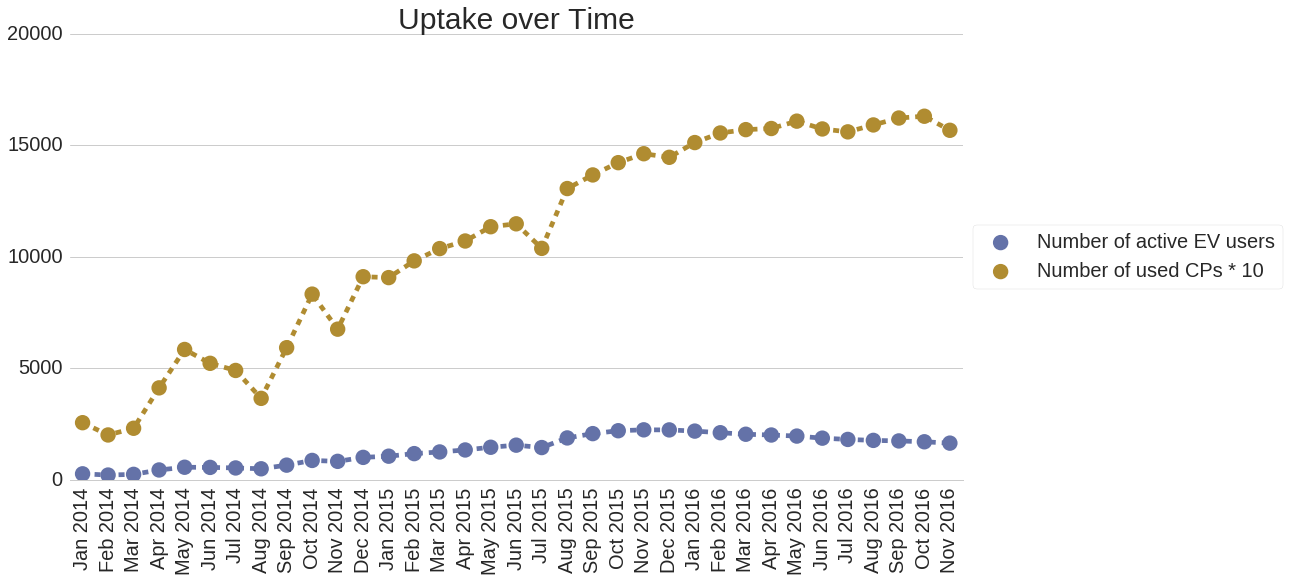

In [9]:
fig = plt.figure(figsize=(16, 8))
seaborn.set(style='whitegrid', font_scale=2)
seaborn.pointplot(x='Times', y='Counts', hue='Types', dodge = False, scale = 1.5, 
                  markers=['o', 'o', 'o', 'o'],  linestyles=['--', '--', '--', '--'], 
                  data = pandas.DataFrame(dataframe), palette=seaborn.color_palette([our_colors[1], our_colors[3], our_colors[2]]), fliersize = 0)
seaborn.despine(left=True)
seaborn.plt.ylim(0,)
plt.title('Uptake over Time', fontsize = 30)
plt.xlabel('')
plt.ylabel('')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
      ncol=1, fancybox=True, frameon=True)
plt.xticks(rotation = 90)
plt.savefig('growth', bbox_inches='tight')
# plt.close(fig)


In [7]:
map_center = [52.179059695, 4.78514509466]
m = ipyleaflet.Map(center = map_center, zoom = 8)

textarea = ipywidgets.Textarea()
textarea.width = '40em'
textarea.height = ''

In [8]:
def clear_map(m):
    current_layers = list(m.layers)[1:]
    for layer in current_layers:
        m.remove_layer(layer)
    layers = []
    
def polygon_generator(offset, size = 1, edge_length_lon = 0.0005, edge_length_lat = 0.0005, shape = 'hexagon'):
    '''
    Generates the coordinates of a hexagon with the center being the offset.

    Args:
        offset: center of the polygon

    Kwargs:
        size: scaling factor for the edge lengths
        edge_length_lon: edge length in longitude direction
        edge_length_lat: edge length in latitude direction
        shape: shape of polygon, e.g. 'hexagon', 'triangle' or 'square'

    Returns:
        An array of coordinates (lon, lat) for the center of the polygon.
    '''

    if shape == 'hexagon':
        stepsize = 60
    elif shape == 'triangle':
        stepsize = 120
    elif shape == 'square':
        stepsize = 90
    else:
        print("Shape undefined in polygon_generator function, now making a hexagon")
        stepsize = 60

#     coords = []
#     lon, lat = offset
#     for angle in range(0, 360, stepsize):
#         lon = numpy.cos(numpy.radians(angle)) * edge_length_lon * size + offset[0]
#         lat = numpy.sin(numpy.radians(angle)) * edge_length_lat * size + offset[1]
#         coords.append([lon, lat])
    coords = [[numpy.cos(numpy.radians(angle)) * edge_length_lon * size + offset[0], numpy.sin(numpy.radians(angle)) * edge_length_lat * size + offset[1]] for angle in range(0, 360, stepsize)]
    return coords

In [9]:
def add_all_css_to_map(m, sessions):    
    clear_map(m)

    features = []
    colors = {'Rotterdam': 'red', 'Amsterdam': 'green', 'Den Haag': 'blue', 'Utrecht': 'purple'}
        
    MAX_SIZE = 500
    total = len(sessions['location_key'].unique())
    for i, cs in enumerate(sessions['location_key'].unique()):
        if i % 100 == 0:
            print("%d of the %d" % (i, total))
        my_sessions = sessions[sessions['location_key'] == cs]
        coordinates = [my_sessions.longitude.values[0],
                       my_sessions.latitude.values[0]]
        city = my_sessions.city.values[0]

        feature = {"type": "Feature", "properties": {"cs": cs,
                                                     "city": city,
                                                     "style": {"fillOpacity": 0.8, "smoothFactor": 0, "stroke": True,
                                                               "color": colors[city], "fillColor": colors[city]}},
                   "geometry": {"type": "Polygon", "coordinates":
                                [polygon_generator(offset = coordinates, size = 0.2, shape = 'square')]}}
        features.append(feature)

    data = {"type": "FeatureCollection", "features": features}

    layer = ipyleaflet.GeoJSON(data = data, hover_style = {'color': 'grey', 'fillColor': 'grey'})

    def click_handler(event=None, id=None, properties=None):
        textarea.value = ("You clicked on a charging station.\n"
                             "Location key(s): \t\t%s\n"
                             "city: \t\t%s\n" % (properties['cs'], properties['city']))

    layer.on_click(click_handler)

    m.add_layer(layer)
    

In [10]:
add_all_css_to_map(m, sessions)  

0 of the 2540
100 of the 2540
200 of the 2540
300 of the 2540
400 of the 2540
500 of the 2540
600 of the 2540
700 of the 2540
800 of the 2540
900 of the 2540
1000 of the 2540
1100 of the 2540
1200 of the 2540
1300 of the 2540
1400 of the 2540
1500 of the 2540
1600 of the 2540
1700 of the 2540
1800 of the 2540
1900 of the 2540
2000 of the 2540
2100 of the 2540
2200 of the 2540
2300 of the 2540
2400 of the 2540
2500 of the 2540


In [11]:
m

In [9]:
textarea